# Categorizing Driver Risk with Machine Learning

Usage-based insurance, also known as pay as you drive, is a type of automobile insurance whereby the costs of motor insurance are dependent upon type of vehicle used, measured against time, distance, behavior and place.

One important requirement of UBI is the ability to quickly quantify or classify the behavior of drivers based on the telemetry data gathered during their recent drives. Insurance companies need this kind of classification to quickly feed the driving pattern (safe or reckless) through into user’s premiums.

This case study describes a project with Toyota where we have constructed a machine learning web service that takes summary telemetry data as the input and assigns a risk rating to the drive.

Getting good labeled data is always a challenge, when building a machine learning model for illustrative purposes we have reduced the problem to categorizing drives into one of four risk categories (0-3), representing excellent, good, fair, and high risk drivers. This allows us to use a supervised learning model which is a good fit for this problem.

For an insurance company, this example can be expanded with data they already have to provide a more complex set of risk classes. Insurance companies will keep the history of these drivers, so they could easily define “excellent” or “risky” according to the accident and insurance rates on different drivers. 

We don’t have such kind of history data, so we have to manually label the data based on our own understanding of safe driving. We believe the classification result will be more reliable if this model is built by insurance companies. 

Here are some of our findings during manual labelling. These observations are not definitive just called out to provide context for others that might manually label driving data.

1.	We defined 4 different categories for drivers:
    1. High 
    2. Fair 
    3. Good 
    4. Low
2.	The main factors that determine the risk rating are Acceleration, Lane Changes, Turns and Braking.
3.	Acceleration and Brake values have positive correlation.
4.	We do have touch or voice data to test our hypotheses around interaction/distraction contributing to risk.

Below you can see the entire machine learning workflow, and run it locally or in your Azure Subscription. To run this in your azure subscription you'll need to create a Azure Machine Learning Workspace (note the workspace id), and retrieve the authorization token for that workspace. These tasks are done via the [Azure Portal](https://portal.azure.com/).

## Setup and Initialization

In [9]:
#
# Here we're setting variables so we don't have to keep entering these 
# strings. We can also now hide these values once, when we publish/share 
# this notebook.
#
import uuid

workspace_id=''
authorization_token=''

# This is set here once so that any re-deployments of the web service below
# *replace* the existing web service, instead of creating a new one for 
# each deployment.

service_id = str(uuid.uuid4())

In [10]:
#
# This initializes the Azure Machine Learning Python Client, found:
# https://github.com/Azure/Azure-MachineLearning-ClientLibrary-Python
#
import pandas
from azureml import Workspace

ws = Workspace(
    workspace_id=workspace_id,
    authorization_token=authorization_token,
    endpoint='https://studioapi.azureml.net'
)

# In my workspace I have the data as a data set, I retrieve it for local 
# processing.

# This is how you read the data from a local file
frame = pandas.read_csv("DriverRisk.csv")

# This is how you read a dataset from the Azure Machine Learning Workspace and Convert it to a Pandas DataFrame.
#ds = ws.datasets['DriverRisk.csv']
#frame = ds.to_dataframe()

## Preparing the Data

In [11]:
# Inspect the first few rows of data.
frame.head()

,TER,TERS,SER,SERS,EHBR,EHBRS,SHBR,SHBRS,ACC,ACCS,...,TURN,TURNS,SHAKE,SHAKES,LANEC,LANECS,USER,TIME,SESSION,CATEGORY
0,14.88,0.067572,0.00,0.00000,0,0,72.29,-0.257627,17.17,0.242583,...,0.45,0.45,1.07,0.022617,4.29,0.417315,aferman,8/23/2013 2:37,FD91E5CE-1CA5-7BD5-E557-23FFB9317899_8.txt,1
1,3.50,0.015894,0.00,0.00000,0,0,22.15,-0.078938,11.49,0.162334,...,0.44,0.44,5.07,0.107166,2.03,0.197471,zhnan,4/23/2013 14:29,9DFCB353-CCCD-6285-F50A-5937B2D6460E_0.txt,3
2,0.00,0.000000,0.00,0.00000,0,0,1.62,-0.005773,2.50,0.035321,...,0.91,0.91,0.00,0.000000,2.50,0.243191,zhnan,5/5/2013 13:09,D967750B-529B-7CFF-4C53-08B0FC1A4F63_6.txt,3
3,8.25,0.037464,8.25,-0.02956,0,0,29.70,-0.105845,5.19,0.073326,...,0.33,0.33,6.92,0.146269,3.46,0.336576,zhnan,3/16/2013 0:24,D838407B-31DE-44EB-DBC1-A0B6D9068C2F_0.txt,3
4,0.00,0.000000,0.00,0.00000,0,0,0.00,0.000000,13.05,0.184374,...,0.22,0.22,0.87,0.018389,3.48,0.338521,zhnan,2/27/2013 13:00,C5765F7B-4A45-5748-C426-F13E8683EF3A_0.txt,3


There are many features in the original dataset, however there aren't that many that are determinants of the risk category. After doing separate experiments to identify the strongest determinant features we identify ACCS, LANECS, TURNS and BRKS as the key features to include.

Here we are selecting a set of columns from the entire list. This subset has been chosen because the correlation of the input featurese against risk category is above an arbitrary threshold. The entire list of raw features is:

In [12]:
# Enumerate the existing column headings.
frame.columns

Index([u'TER', u'TERS', u'SER', u'SERS', u'EHBR', u'EHBRS', u'SHBR', u'SHBRS',
       u'ACC', u'ACCS', u'BRK', u'BRKS', u'TURN', u'TURNS', u'SHAKE',
       u'SHAKES', u'LANEC', u'LANECS', u'USER', u'TIME', u'SESSION',
       u'CATEGORY'],
      dtype='object')

From those we select: ACCS,LANECS,TURNS,BRKS
Note: the the difference between TER and TERS is the TERS column (like all the columns with the extra S) is normalized data.

In [13]:
# Pick just the major determinants for the model
# TODO: Show the component analysis that drives this selection.
feature_cols = ['ACCS', 'LANECS', 'TURNS', 'BRKS']

In [14]:
# Process the basic data into feature vector data and labeled category
# data. We use numpy and sklearn tools to massage the data.

import numpy as np
from sklearn.preprocessing import label_binarize

# Pull out features we care about and category labels
X = frame[feature_cols]
y_raw = frame.CATEGORY

# This creates four classes from the raw data
y = label_binarize(y_raw, classes=np.unique(y_raw))
n_classes = y.shape[1]

In [15]:
# We split the (limited amount of) data we have into training and test data.

import numpy as np
from sklearn.cross_validation import train_test_split

# Split data into train and test
random_state = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.6, 
                                                    random_state=random_state)

## Building and Training the Model

In [16]:
# Here we actually instantiate and train the multi-classs classifier.

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

# Build the one vs all classifier (and test it)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, 
                                         random_state=random_state))

## Quick Performance Inspection

In [17]:
# Here we generate labels for the test data to compare against the actual
# labels.
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [18]:
# We compute some basic statistics about the classifiers performance
# using the test data.

import numpy as np
obs = y_score
pred = y_test

mae = np.mean(abs(pred-obs))
rmse = np.sqrt(np.mean((pred-obs)**2))
rae = np.mean(abs(pred-obs))/np.mean(abs(obs-np.mean(obs)))
rse = np.mean((pred-obs)**2)/np.mean((obs-np.mean(obs))**2)

print("Mean Absolute Error: " + str(round(mae,6)))
print("Root Mean Squared Error: " + str(round(rmse,6)))
print("Relative Absolute Error: " + str(round(rae,6)))
print("Relative Squared Error: " + str(round(rse,6)))

Mean Absolute Error: 1.424722
Root Mean Squared Error: 1.594763
Relative Absolute Error: 2.878017
Relative Squared Error: 3.947494


## A Deeper Look at Precision and Recall

In [19]:
# This shows how to generate the precision and recall curves.
# We generate these curves for each category.

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")

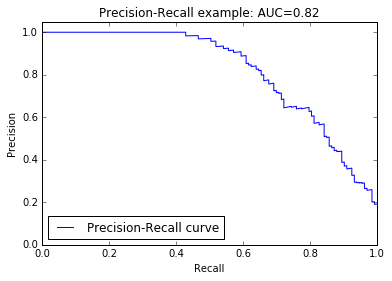

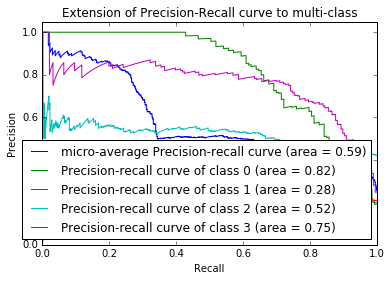

In [25]:
# Plot the precision and recall curves.
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

## Deploy the Model as an Azure Machine Learning Web Service

In [ ]:
# This is how to deploy the model to Azure Machine Learning as a web
# service. By doing this, others can invoke the model with their telemetry
# data to get a risk rating for their data.
#
# This webservice is exactly the same as a Azure Machine Learning web
# service deployed from the AzureML Studio -- all the same examples and
# and sample code are available.

import uuid
from azureml import services

@services.publish(workspace_id, authorization_token)
# This is where we set the service_id, created above. Not including this
# line would result in a new service being created for each invocation.
@services.service_id(service_id)
@services.types(accs=float, lanecs=float, turns=float, brks=float)
@services.returns(float)
def demoservice(accs, lanecs, turns, brks):
    # predict the risk rating category
    return classifier.predict([accs, lanecs, turns, brks])

## Use Azure Machine Learning Web Service Version

In [ ]:
# Here's a simple test showing how to use the deployed web service.
test_row = 0
obs = y_raw.iloc[test_row]
feature_vec = X.iloc[test_row]
result = demoservice(feature_vec.ACCS, feature_vec.LANECS, 
                     feature_vec.TURNS, feature_vec.BRKS)
result

## Opportunities for Reuse

Since this notebook lives in github, there are at least two reusable components:

1. The Machine Learning Model, Data, and Services can be instantiated by anyone in their subscription and they can create a risk rating service. This in fact makes it easier for us to build a machine learning solution with a partner and give it to them to continue to use after our collaboration has ended. This addresses one particular challenge the Azure Machine Learning Studio doesn't quite address (yet).

2. The Jupyter notebook can be modified and reused as a means to explore machine learning algorithms locally (on a local laptop), then when ready can be "productionized" into Azure.